/home/cedric/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
==((====))==  Unsloth 2024.8: Fast Llama patching. Transformers = 4.44.2.
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.394 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.4.0+cu121. CUDA = 8.0. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.27.post2. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Unsloth 2024.8 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.
/home/cedric/venv/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/home/cedric/venv/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 402 | Num Epochs = 30
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 1,500
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
50,0.440500,0.435852
100,0.355100,0.394614
150,0.291500,0.395431
200,0.244100,0.405789
250,0.194700,0.420728
300,0.161700,0.429245
350,0.134900,0.442550
400,0.105600,0.479634
450,0.095900,0.486156
500,0.080800,0.510827


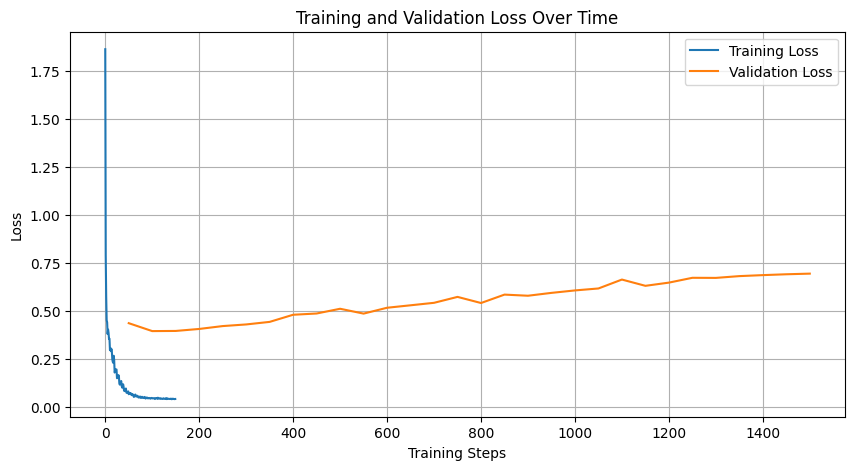

In [1]:
import os
import torch
from datasets import load_dataset
from transformers import TrainingArguments, IntervalStrategy
import matplotlib.pyplot as plt
from trl import SFTTrainer
from unsloth import FastLanguageModel
from unsloth import is_bfloat16_supported

# Set GPU configuration
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

# Model configuration
max_seq_length = 2048  # Choose any! We auto support RoPE Scaling internally!
dtype = None  # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True  # Use 4bit quantization to reduce memory usage. Can be False.

# Load the model and tokenizer
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="unsloth/Meta-Llama-3.1-8B",
    max_seq_length=max_seq_length,
    dtype=dtype,
    load_in_4bit=load_in_4bit,
    device_map={"": 0}  # Forces all layers to GPU 0
)

# Configure PEFT model
model = FastLanguageModel.get_peft_model(
    model,
    r=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_alpha=16,
    lora_dropout=0,
    bias="none",
    use_gradient_checkpointing="unsloth",
    random_state=3407,
    use_rslora=False,
    loftq_config=None,
)

# Load and split the dataset
dataset = load_dataset("json", data_files="/home/cedric/venv/data/train_data.json")['train']
train_test_split = dataset.train_test_split(test_size=0.2, seed=42)

train_dataset = train_test_split['train']
val_dataset = train_test_split['test']

# Prompt formatting function
alpaca_prompt = """Below is a question regarding a SPARQL database. Your objective is to provide a SPARQL query that would retrieve the necessary information to answer the question.
### Input:
{}

### Response:
{}"""
EOS_TOKEN = tokenizer.eos_token

def formatting_prompts_func(examples):
    inputs = examples["question"]
    outputs = examples["sparql"]
    texts = []
    for input, output in zip(inputs, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = alpaca_prompt.format(input, output) + EOS_TOKEN
        texts.append(text)
    return {"text": texts}

# Apply the formatting function and rename the text column correctly
train_dataset = train_dataset.map(formatting_prompts_func, batched=True)
val_dataset = val_dataset.map(formatting_prompts_func, batched=True)

# Updated TrainingArguments to include validation during training
training_args = TrainingArguments(
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    warmup_steps=5,
    max_steps=1500,
    learning_rate=2e-4,
    fp16=not is_bfloat16_supported(),
    bf16=is_bfloat16_supported(),
    logging_steps=10,  # Log every 10 steps
    evaluation_strategy=IntervalStrategy.STEPS,  # Enable evaluation during training
    eval_steps=50,  # Perform validation every 50 steps
    save_steps=100,  # Save the model every 100 steps
    optim="adamw_8bit",
    weight_decay=0.01,
    lr_scheduler_type="linear",
    seed=3407,
    output_dir="outputs",
)

# Initialize the trainer with the correctly processed datasets and updated arguments
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_dataset,  # Use processed dataset here
    eval_dataset=val_dataset,  # Add this line if you want validation
    dataset_text_field="text",  # Ensure this matches the field created by formatting_prompts_func
    max_seq_length=max_seq_length,
    dataset_num_proc=2,
    packing=False,  # Can make training 5x faster for short sequences.
    args=training_args,
)

# Train the model
trainer_stats = trainer.train()

# Save the model and tokenizer
model.save_pretrained("/home/cedric/venv/model_checkpoints/Llama_3.1_8B")
tokenizer.save_pretrained("/home/cedric/venv/model_checkpoints/Llama_3.1_8B")

# Extract and plot the training and validation loss
train_loss_values = []
eval_loss_values = []
eval_steps = []

for log in trainer.state.log_history:
    if "loss" in log:
        train_loss_values.append(log["loss"])
    if "eval_loss" in log:
        eval_loss_values.append(log["eval_loss"])
        eval_steps.append(log["step"])

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(len(train_loss_values)), train_loss_values, label="Training Loss")
plt.plot(eval_steps, eval_loss_values, label="Validation Loss")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Time")
plt.legend()
plt.grid(True)
plt.show()


In [2]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
import difflib
FastLanguageModel.for_inference(model)
final_data = []

dataset = load_dataset("json", data_files="/home/cedric/venv/data/test_data.json")['train']
# Iterate over the test dataset
for example in dataset:
    input_question = example['question']
    expected_output = example['sparql']
    
    # Tokenize the input question
    inputs = tokenizer(
        [alpaca_prompt.format(input_question, "")], return_tensors="pt"
    ).to("cuda")
    
    # Generate the output
    generated_output = model.generate(**inputs, max_new_tokens=500)[0]
    generated_text = tokenizer.decode(generated_output, skip_special_tokens=True)
    
    # Extract the relevant part of the generated text
    generated_text = generated_text.split("### Response:")[1].strip() 
    print(f"Generated Text: {generated_text}")
    print(f"Expected Output: {expected_output}")
    
    # Prepare reference and hypothesis for metrics calculation
    reference = expected_output
    hypothesis = generated_text
    
    # BLEU Score with Smoothing
    reference_tokens = [reference.split()]
    hypothesis_tokens = hypothesis.split()

    weights = (0.5, 0.5, 0.0, 0.0)  # Unigrams and bigrams
    smoothing_function = SmoothingFunction().method1
    bleu_score = sentence_bleu(reference_tokens, hypothesis_tokens, weights=weights, smoothing_function=smoothing_function)
    
    # Initialize ROUGE scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, hypothesis)
    
    # Calculate average ROUGE scores
    average_precision = (scores['rouge1'].precision + scores['rouge2'].precision + scores['rougeL'].precision) / 3
    average_recall = (scores['rouge1'].recall + scores['rouge2'].recall + scores['rougeL'].recall) / 3
    average_f1 = (scores['rouge1'].fmeasure + scores['rouge2'].fmeasure + scores['rougeL'].fmeasure) / 3
    rouge_averages = [average_precision, average_recall, average_f1]
    
    # METEOR Score
    meteor = meteor_score(reference_tokens, hypothesis_tokens)
    
    # String Similarity
    similarity = difflib.SequenceMatcher(None, reference, hypothesis).ratio()
    print(similarity)
    
    # Combine results into the final row
    final_row = [input_question, expected_output, generated_text, bleu_score] + rouge_averages + [meteor, similarity]
    final_data.append(final_row)

    print(f"Processed example: {len(final_data)}")

# Print the final results
print(f'Total processed examples: {len(final_data)}')

# Calculate averages for metrics
bleu_scores = [row[3] for row in final_data]
rouge_scores = [row[4:7] for row in final_data]
meteor_scores = [row[7] for row in final_data]
string_comparisons = [row[8] for row in final_data]

print(f'Average BLEU score: {sum(bleu_scores) / len(bleu_scores):.4f}')
print(f'Average prec score: {sum([r[0] for r in rouge_scores]) / len(rouge_scores):.4f}')
print(f'Average recall R score: {sum([r[1] for r in rouge_scores]) / len(rouge_scores):.4f}')
print(f'Average ROUGE-1 F1 score: {sum([r[2] for r in rouge_scores]) / len(rouge_scores):.4f}')
print(f'Average METEOR score: {sum(meteor_scores) / len(meteor_scores):.4f}')
print(f'Exact string match percentage: {sum(string_comparisons) / len(string_comparisons) * 100:.2f}%')


Generated Text: PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX metadb_riken_jp: <http://metadb.riken.jp/>
PREFIX db: <http://metadb.riken.jp/db/>
PREFIX SciNetS_rib35i: <http://metadb.riken.jp/db/SciNetS_rib35i/>

SELECT?term 
FROM <http://metadb.riken.jp/db/SciNetS_rib35i>
WHERE {
 ?class?term?value.
  FILTER(CONTAINS(str(?value), "Pfam"))
}
Expected Output: PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX metadb_riken_jp: <http://metadb.riken.jp/>
PREFIX db: <http://metadb.riken.jp/db/>

SELECT ?term
FROM <http://metadb.riken.jp/db/SciNetS_rib125i>
WHERE {
  <http://metadb.riken.jp/db/SciNetS_rib125i> ?p ?term.
}
0.6777408637873754
Processed example: 1
Generated Text: PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX item: <http://database.riken.jp/sw/item/>

SELECT?attribute
FROM <http://metadb.riken.jp/db/SciNetS_ria301i>
WHERE {
  item:cria301s4i?attribute?value.
}
Expected Output: PREFIX item: <http://database.riken.jp/sw/item/>

SELECT ?attribute
FROM <http://